# AT&T => DEEP LEARNING PROJET

## 1. IMPORT COMMON LIB

In [ ]:
# prevent warning
import warnings
warnings.filterwarnings("ignore")

# clear outputs
from IPython.display import clear_output

# base lib
import pandas as pd
import numpy as np
import chardet
from sklearn.model_selection import train_test_split

# viz lib
import matplotlib.pyplot as plt
import seaborn as sns

# preprocess lib
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import tiktoken

# Pytorch lib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary

# import lib transformer
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import Dataset as dset

# controle device ligne
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
device_name = torch.cuda.get_device_name(0)

print("Device actuel :", device)
print("CUDA disponible :", torch.cuda.is_available())
print("Nombre de GPU :", torch.cuda.device_count())
print("Nom GPU :", torch.cuda.get_device_name(0))

Device actuel : 0
CUDA disponible : True
Nombre de GPU : 1
Nom GPU : NVIDIA GeForce RTX 3080


## 2. Import the dataset

In [2]:
# pour la detection d'encodage
csv_path = "spam.csv"

with open(csv_path, "rb") as original_file:
    data_to_decode = original_file.read()
encoding_result = chardet.detect(data_to_decode)
detected_encoding = encoding_result["encoding"]
print(detected_encoding)

Windows-1252


In [ ]:
# essai de plusieur encodage pour voir lequel fonctionne

encodings_to_try = ['utf-8','utf-16', 'utf-8-sig', 'utf_32', 'utf_32_be', 'utf_32_le', 'utf_7', 'cp1252', 'ISO-8859-1','latin','latin9']

for enc in encodings_to_try:
    try:
        df = pd.read_csv(csv_path, encoding=enc)
        print(f"✅ Chargé avec succès en encodage : {enc}")
    except UnicodeDecodeError:
        print(f"❌ Échec avec encodage : {enc}")

❌ Échec avec encodage : utf-8
❌ Échec avec encodage : utf-16
❌ Échec avec encodage : utf-8-sig
❌ Échec avec encodage : utf_32
❌ Échec avec encodage : utf_32_be
❌ Échec avec encodage : utf_32_le
❌ Échec avec encodage : utf_7
✅ Chargé avec succès en encodage : cp1252
✅ Chargé avec succès en encodage : ISO-8859-1
✅ Chargé avec succès en encodage : latin
✅ Chargé avec succès en encodage : latin9


In [4]:
# choix encodage cp-1252
df = pd.read_csv(csv_path, encoding='cp1252')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## 3. First Step => read data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
for val in df['Unnamed: 2']:
    if not pd.isna(val):
        print(val)

 PO Box 5249
 the person is definitely special for u..... But if the person is so special
 HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\""
 wanted to say hi. HI!!!\" Stop? Send STOP to 62468"
this wont even start........ Datz confidence.."
 PO Box 5249
GN
.;-):-D"
just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\""
 bt not his girlfrnd... G o o d n i g h t . . .@"
 I'll come up"
 don't miss ur best life for anything... Gud nyt..."
 just as a shop has to give a guarantee on what they sell. B. G."
 But at d end my love compromised me for everything:-(\".. Gud mornin:-)"
 the toughest is acting Happy with all unspoken pain inside..\""
 smoke hella weed\""
\" not \"what i need to do.\""
JUST GOT PAYED2DAY & I HAVBEEN GIVEN Aå£50 PAY RISE 4MY WORK & HAVEBEEN MADE PRESCHOOLCO-ORDINATOR 2I AM FEELINGOOD LUV\""
 justthought iåÕd sayhey! how u doin?nearly the endof me wk offdam nevamind!We will have 2Hook up sn if uwant m8? loveJen x.\""
JUST REALLYNEED 2DOCD

In [8]:
for val in df['Unnamed: 3']:
    if not pd.isna(val):
        print(val)

 MK17 92H. 450Ppw 16"
 why to miss them
 MK17 92H. 450Ppw 16"
GE
U NO THECD ISV.IMPORTANT TOME 4 2MORO\""
i wil tolerat.bcs ur my someone..... But
 ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\""
whoever is the KING\"!... Gud nyt"
 TX 4 FONIN HON
 \"OH No! COMPETITION\". Who knew
GE
IåÕL CALL U\""


In [9]:
for val in df['Unnamed: 4']:
    if not pd.isna(val):
        print(val)

 just Keep-in-touch\" gdeve.."
GNT:-)"
 Never comfort me with a lie\" gud ni8 and sweet dreams"
 CALL 2MWEN IM BK FRMCLOUD 9! J X\""
 one day these two will become FREINDS FOREVER!"
GNT:-)"


## 4. preprocess

In [10]:
# copie des data pour etre sur a ne pas avoir a les reimporter
df_v1 = df.copy(deep=True)
df_v1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
# remplir les cells vide et fusionner les colonnes

for i in range(2,5,1):
    df_v1[f'Unnamed: {i}'] = df_v1[f'Unnamed: {i}'].fillna("")

df_v1['v2']=pd.concat([df_v1['v2'],df_v1['Unnamed: 2'],df_v1['Unnamed: 3'],df_v1['Unnamed: 4']], ignore_index=True)

df_v1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,Ok lar... Joking wif u oni...,,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [12]:
# renommer les colonnes et drop colonnes vides
df_v1 = df_v1[['v1', 'v2']].set_axis(['label', 'text'], axis=1)
df_v1.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# transformer les label ham/spam en => 0/1
df_v1['label'] = df_v1['label'].map({'ham':0,'spam':1})
df_v1.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# calcul du pourcentage de spam dans l'ensemble du corpus
percent = (df_v1['label'].mean())*100
print(f'pourcentage de spam dans le corpus : {percent:,.2f} %')

pourcentage de spam dans le corpus : 13.41 %


In [15]:
# Tentative de nettoyage du text, non optimale pour apprentissage et prediction !

# # test nettoyage sur copy 2
# df_v2 = df_v1.copy(deep=True)
# df_v2

# # Supprimer les espaces multiples et sauts
# df_v2['text'] = df_v2['text'].replace(r' +', ' ').str.strip()

# nlp = spacy.load("en_core_web_sm")

# def lemmatize_and_clean(text):
#     doc = nlp(text)
#     lemmas = [
#         token.lemma_
#         for token in doc
#         if token.lemma_ not in STOP_WORDS and token.text not in STOP_WORDS and not token.is_punct
#     ]
#     return " ".join(lemmas)

# df_v2['text'] = df_v2['text'].apply(lemmatize_and_clean)

## 5. Home working

### 5.1 select df

In [16]:
# en attente de decision travaux sur le df non modifié et encodage CP1252
df_v1.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 5.2 Preprocessing for embedding work

We will now go through a preprocessing phase. The goal is to convert the character strings into sequences of tokens represented by integers.

1. Use the tiktoken library in order to tokenize each sentence based on the `cl100k_base` tokenizer.

In [17]:
tokenizer = tiktoken.get_encoding("cl100k_base")

def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

train_tokens = encode_texts(df_v1['text'])

# print the first ten tokens of the first tokenized sentence
train_tokens[0][:10]

[11087, 3156, 16422, 647, 1486, 11, 14599, 497, 16528, 1193]

2. In order to build the data loader, we need all sequences to be of the same length. Calculate the max and average senquence length, and decide which length you want all sequences to adopt.

In [18]:
# # How are sequence lengths distributed?
# seq_lens = [len(seq) for seq in train_tokens]
# print("avg seq len",np.mean(seq_lens))
# print("max seq len",np.max(seq_lens))

avg seq len : 22.48707824838478
max seq len : 259
min seq len : 1


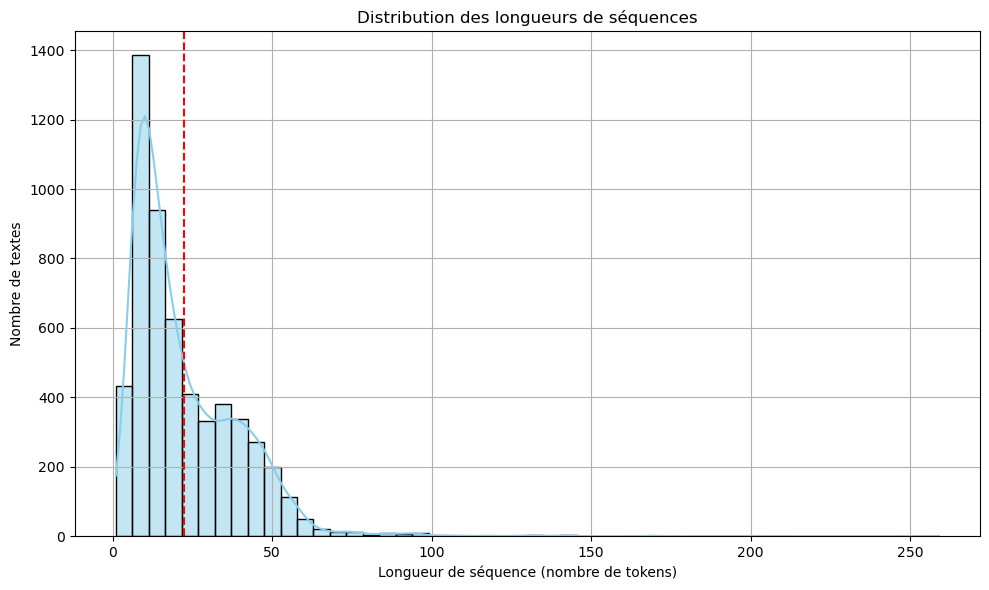

In [19]:
# Longueurs des séquences
seq_lens = [len(seq) for seq in train_tokens]

# Statistiques utiles
print("avg seq len :", np.mean(seq_lens))
print("max seq len :", np.max(seq_lens))
print("min seq len :", np.min(seq_lens))

# Tracé de l’histogramme
plt.figure(figsize=(10, 6))
sns.histplot(seq_lens, bins=50, kde=True, color='skyblue')
plt.title("Distribution des longueurs de séquences")
plt.xlabel("Longueur de séquence (nombre de tokens)")
plt.ylabel("Nombre de textes")
plt.axvline(x=np.mean(seq_lens), color='red', linestyle='--', label='Moyenne')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
def pad_sequences(sequences, max_length=200):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

train_tokens = pad_sequences(train_tokens)

3. Form a torch dataset object based on the token sequences and labels, and split the data into a train and validation set.

In [ ]:
# Define a custom PyTorch dataset class for SPAM detection
class SPAMDataset(Dataset):
    """
    A custom dataset class for SPAM detection.

    This class is used to convert text data (already tokenized) and their corresponding labels
    into a PyTorch Dataset object, which can be easily loaded into a DataLoader.
    """

    def __init__(self, texts, labels):
        """
        Initializes the dataset by storing texts and labels as PyTorch tensors.

        Args:
        - texts (list or numpy array): Tokenized text data, where each text has been converted
                                       into a sequence of word indices (integer tokens).
        - labels (list or numpy array): The corresponding labels for each text .
        """
        # Convert text sequences to a PyTorch tensor (long type since they are indices)
        self.texts = torch.tensor(texts, dtype=torch.long)

        # Convert labels to a PyTorch tensor (float32 for compatibility with loss functions)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        This method is required for PyTorch datasets as it allows DataLoader to determine
        how many batches it needs.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves a single data point (text and label) from the dataset based on an index.

        Args:
        - idx (int): Index of the sample to retrieve.

        Returns:
        - tuple: A tuple containing:
            - self.texts[idx]: The tokenized text at index `idx`.
            - self.labels[idx]: The corresponding label for that text.
        """
        return self.texts[idx], self.labels[idx]

# Example usage: Creating a dataset instance
df_dataset = SPAMDataset(train_tokens, df_v1['label'])

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(df_dataset))
val_size = len(df_dataset) - train_size
train_dataset, val_dataset = random_split(df_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [22]:
text, label = next(iter(train_loader))
print(label)
print(text)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[   71,  4336,   856,  ...,     0,     0,     0],
        [27997,  3488,   449,  ...,     0,     0,     0],
        [   51,   434,    88,  ...,     0,     0,     0],
        ...,
        [ 9906,    11,   856,  ...,     0,     0,     0],
        [13347, 27046, 40276,  ...,     0,     0,     0],
        [ 5519,  1717,   234,  ...,     0,     0,     0]])


We have imported data corresponding to spam classication organized in binary categories.   
We'll load the text data into python variables.

### 5.3 Home Text Classification

In [23]:
vocab_size = tokenizer.n_vocab

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        return torch.sigmoid(self.fc(pooled))

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=16,
                      num_class=1)

In [24]:
from torchinfo import summary

print(model)

# Print model summary
summary(model, input_data=text)


TextClassifier(
  (embedding): Embedding(100277, 16, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 200, 16]             1,604,432
├─AdaptiveAvgPool1d: 1-2                 [32, 16, 1]               --
├─Linear: 1-3                            [32, 1]                   17
Total params: 1,604,449
Trainable params: 1,604,449
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.34
Input size (MB): 0.05
Forward/backward pass size (MB): 0.82
Params size (MB): 6.42
Estimated Total Size (MB): 7.29

We'll then compile the model

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=200, device=device):
    """
    Function to train a PyTorch model with training and validation datasets.

    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).

    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model = model.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            #probs = torch.sigmoid(outputs)
            # preds = (probs > 0.5).float()
            # correct += (preds == labels).sum().item()
            correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions


        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)


        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                model = model.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                # val_probs = torch.sigmoid(outputs)
                # val_preds = (val_probs > 0.5).float()
                # val_correct += (val_preds == labels).sum().item()
                val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=60, 
                device=device)

Epoch [1/60], Loss: 0.7449, Acc: 0.1326, Val Loss: 0.7104, Val Acc: 0.1740
Epoch [2/60], Loss: 0.6783, Acc: 0.6475, Val Loss: 0.6424, Val Acc: 0.8682
Epoch [3/60], Loss: 0.6052, Acc: 0.8773, Val Loss: 0.5677, Val Acc: 0.8601
Epoch [4/60], Loss: 0.5284, Acc: 0.8824, Val Loss: 0.4933, Val Acc: 0.8780
Epoch [5/60], Loss: 0.4571, Acc: 0.8975, Val Loss: 0.4269, Val Acc: 0.8933
Epoch [6/60], Loss: 0.3948, Acc: 0.9080, Val Loss: 0.3710, Val Acc: 0.9040
Epoch [7/60], Loss: 0.3420, Acc: 0.9239, Val Loss: 0.3240, Val Acc: 0.9184
Epoch [8/60], Loss: 0.2986, Acc: 0.9365, Val Loss: 0.2850, Val Acc: 0.9363
Epoch [9/60], Loss: 0.2617, Acc: 0.9477, Val Loss: 0.2524, Val Acc: 0.9462
Epoch [10/60], Loss: 0.2309, Acc: 0.9547, Val Loss: 0.2251, Val Acc: 0.9525
Epoch [11/60], Loss: 0.2049, Acc: 0.9625, Val Loss: 0.2025, Val Acc: 0.9578
Epoch [12/60], Loss: 0.1830, Acc: 0.9690, Val Loss: 0.1835, Val Acc: 0.9614
Epoch [13/60], Loss: 0.1651, Acc: 0.9726, Val Loss: 0.1679, Val Acc: 0.9641
Epoch [14/60], Loss: 

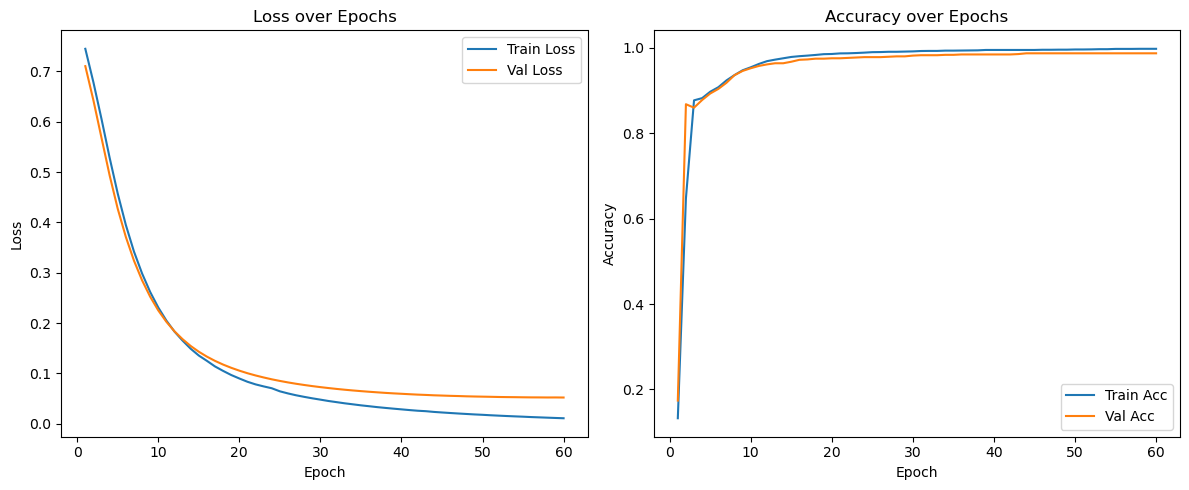

In [26]:
epochs = range(1, len(history['loss'])+1)

plt.figure(figsize=(12, 5))

# Courbe de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Courbe d'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Train Acc')
plt.plot(epochs, history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


### 5.4 Error analysis

In [27]:
# Function to evaluate the model and get worst predictions
def evaluate_worst_predictions(model, dataloader, tokenizer, device=device):
    model.eval()  # Set model to evaluation mode
    
    all_predictions = []
    all_labels = []
    all_errors = []
    all_inputs = []

    with torch.no_grad():  # No gradients needed during evaluation
        for batch in dataloader:
            inputs, labels = batch  # Assuming (inputs, labels) in DataLoader
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            model.to(device)
            outputs = model(inputs)

            # Convert outputs to predicted class (for classification)
            if outputs.shape[-1] > 1:  # Multi-class classification
                preds = torch.argmax(outputs, dim=1)
                errors = (preds != labels).float()  # Misclassified observations
            else:  # Regression
                preds = outputs.squeeze()
                errors = torch.abs(preds - labels)  # Absolute error

            # Save results
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_errors.extend(errors.cpu().numpy())
            all_inputs.extend(inputs.cpu().numpy())

    # Convert to DataFrame for analysis
    df_results = pd.DataFrame({
        "True_Label": all_labels,
        "Predicted": all_predictions,
        "Error": all_errors,
        "Inputs": all_inputs,
        "Text" : [tokenizer.decode(input) for input in all_inputs]
    })

    # Sort by highest error (worst predictions)
    df_results_sorted = df_results.sort_values(by="Error", ascending=False)

    return df_results_sorted

# Example usage:
worst_predictions_val = evaluate_worst_predictions(model, val_loader, tokenizer, device=device)
worst_predictions_train = evaluate_worst_predictions(model, train_loader, tokenizer, device=device)


2. Display the first ten rows of each dataframe to get an idea of the worst predicted data points. Is there anything that raises questions?

In [28]:
worst_predictions_train.head(10)

,True_Label,Predicted,Error,Inputs,Text
3578,1.0,0.009867,0.990133,"[9906, 76745, 1268, 527, 499, 3432, 30, 358, 1...",Hello darling how are you today? I would love ...
2075,1.0,0.054529,0.945471,"[5519, 499, 3596, 5406, 430, 994, 499, 2351, 1...","Do you ever notice that when you're driving, a..."
2646,1.0,0.098888,0.901112,"[25821, 602, 617, 2834, 3243, 287, 1396, 220, ...",Money i have won wining number 946 wot do i do...
3389,1.0,0.169194,0.830806,"[5519, 499, 13383, 430, 304, 922, 220, 1272, 1...","Do you realize that in about 40 years, we'll h..."
3356,1.0,0.196499,0.803501,"[9906, 13, 1226, 1205, 1063, 1153, 71, 20229, ...",Hello. We need some posh birds and chaps to us...
942,1.0,0.286516,0.713484,"[13347, 420, 374, 29793, 11, 584, 690, 387, 11...","Hi this is Amy, we will be sending you a free ..."
1986,1.0,0.353978,0.646022,"[4438, 2586, 433, 5097, 779, 2697, 892, 369, 2...",How come it takes so little time for a child w...
77,1.0,0.404188,0.595812,"[7131, 499, 6865, 922, 279, 502, 1144, 12792, ...","Did you hear about the new \Divorce Barbie\""? ..."
357,1.0,0.480750,0.519250,"[2028, 1984, 374, 7263, 311, 499, 555, 19722, ...",This message is brought to you by GMW Ltd. and...
2272,1.0,0.586283,0.413717,"[33092, 5513, 0, 10289, 8216, 27306, 23130, 11...","Latest News! Police station toilet stolen, cop..."


In [29]:
worst_predictions_val.head(10)

,True_Label,Predicted,Error,Inputs,Text
334,1.0,0.000286,0.999714,"[43, 40777, 706, 2646, 1027, 420, 1790, 2523, ...",LIFE has never been this much fun and great un...
520,1.0,0.000908,0.999092,"[14442, 15007, 617, 1047, 1403, 315, 1521, 13,...",dating:i have had two of these. Only started a...
693,1.0,0.003229,0.996771,"[12174, 856, 10087, 0, 358, 3077, 1766, 701, 1...",Oh my god! I've found your number again! I'm s...
881,1.0,0.006248,0.993752,"[19701, 358, 13942, 701, 1650, 1095, 596, 3137...",Sorry I missed your call let's talk when you h...
219,1.0,0.026573,0.973427,"[29089, 499, 1093, 311, 1518, 856, 20572, 2206...",Would you like to see my XXX pics they are so ...
605,1.0,0.046394,0.953606,"[4061, 4470, 22991, 4718, 74448, 20114, 571, 3...",Check Out Choose Your Babe Videos @ sms.shsex....
505,1.0,0.054369,0.945631,"[66665, 13, 1645, 12438, 1030, 25, 12634, 374,...","SMS. ac JSco: Energy is high, but u may not kn..."
1098,1.0,0.060788,0.939212,"[51, 7497, 16744, 4419, 1971, 11417, 13, 1027,...",TBS/PERSOLVO. been chasing us since Sept forå£...
946,1.0,0.123096,0.876904,"[11787, 499, 5016, 3403, 30, 7531, 704, 505, 2...",Are you unique enough? Find out from 30th Augu...
448,1.0,0.137859,0.862141,"[36412, 291, 1650, 5225, 13, 4314, 5219, 2663,...",Missed call alert. These numbers called but le...


Something seems immediatly off. Some reviews in the training set use very postive vocabulary associated with one star reviews, this must throw the model off.

On the validation set, most of the worst predicted observations also had a true label of one star.

3. Calculate the mean error for each category of the target. Also calculate the number of samples belonging to each category. What do you think?

In [30]:
from sklearn.metrics import classification_report
true_labels = worst_predictions_train['True_Label']
predicted_labels = np.round(worst_predictions_train['Predicted'])
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3874
         1.0       1.00      0.98      0.99       583

    accuracy                           1.00      4457
   macro avg       1.00      0.99      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [31]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
confusion_train = pd.DataFrame(confusion_matrix(predicted_labels, true_labels),
             columns=["pred_HAM","pred_SPAM"],
             index=["true_HAM","true_SPAM"])
px.imshow(confusion_train,
          text_auto=True)

In [32]:
from sklearn.metrics import classification_report
true_labels_val = worst_predictions_val['True_Label']
predicted_labels_val = np.round(worst_predictions_val['Predicted'])
print(classification_report(true_labels_val, predicted_labels_val))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       951
         1.0       1.00      0.91      0.96       164

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [33]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
confusion_val = pd.DataFrame(confusion_matrix(predicted_labels_val, true_labels_val),
             columns=["pred_HAM","pred_SPAM"],
             index=["true_HAM","true_SPAM"])
px.imshow(confusion_val,
          text_auto=True)

In [34]:
print("Train set prediction error by class")
worst_predictions_train.groupby("True_Label")["Error"].mean()


Train set prediction error by class


True_Label
0.0    0.005538
1.0    0.023624
Name: Error, dtype: float32

In [35]:
print("Train set distribution")
worst_predictions_train["True_Label"].value_counts()


Train set distribution


True_Label
0.0    3874
1.0     583
Name: count, dtype: int64

In [36]:
print("Validation set prediction error by class")
worst_predictions_val.groupby("True_Label")["Error"].mean()


Validation set prediction error by class


True_Label
0.0    0.007518
1.0    0.093946
Name: Error, dtype: float32

In [37]:
print("Validation set spam distribution")
worst_predictions_val["True_Label"].value_counts()


Validation set spam distribution


True_Label
0.0    951
1.0    164
Name: count, dtype: int64

=> essayons avec  pour plusieurs raisons :   
1- train acc = 1 et val acc < 1    
2- dataset petit   
3- repartition des spam/ham trop faible (13% de spam sur tout le corpus)

## 6. let's try Bumblebee 🤖

1. Use the tiktoken library in order to tokenize each sentence based on the `cl100k_base` tokenizer.

In [38]:
df_dtrans = df_v1.copy(deep=True)
df_dtrans.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [39]:
dataset_dftrans = dset.from_pandas(df_dtrans)
dataset_dftrans

Dataset({
    features: ['label', 'text'],
    num_rows: 5572
})

In [40]:
# Découpage 80% / 20% (train / validation)
split_dataset = dataset_dftrans.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

print(f"Train set : {len(train_dataset)} samples")
print(f"Validation set : {len(val_dataset)} samples")

Train set : 4457 samples
Validation set : 1115 samples


In [41]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True)

tok_df_train_dtrans = train_dataset.map(tokenize_function, batched=True)
tok_df_val_trans = val_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 1115/1115 [00:00<00:00, 9883.32 examples/s] 


In [42]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [43]:
training_args = TrainingArguments("test-trainer",report_to="none")

In [44]:
model_trans = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
trainer = Trainer(
    model_trans,
    training_args,
    train_dataset= tok_df_train_dtrans,
    eval_dataset= tok_df_val_trans,
    data_collator=data_collator,
    processing_class=tokenizer,
)

In [46]:
trainer.train()

Step,Training Loss
500,0.086000
1000,0.035500
1500,0.009400


TrainOutput(global_step=1674, training_loss=0.039799312252012775, metrics={'train_runtime': 197.6324, 'train_samples_per_second': 67.656, 'train_steps_per_second': 8.47, 'total_flos': 1620040031726580.0, 'train_loss': 0.039799312252012775, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(tok_df_val_trans)
# print(predictions.predictions.shape, predictions.label_ids.shape)

(1115, 2) (1115,)


In [48]:
preds_trans = np.argmax(predictions.predictions, axis=-1)

In [49]:
from sklearn.metrics import classification_report
true_labels_trans = tok_df_val_trans["label"]
print(classification_report(true_labels_trans, preds_trans))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       970
           1       0.99      0.97      0.98       145

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115



In [50]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
confusion = pd.DataFrame(confusion_matrix(preds_trans, true_labels_trans),
             columns=["pred_HAM","pred_SPAM"],
             index=["true_HAM","true_SPAM"])
px.imshow(confusion,
          text_auto=True)
